<a href="https://colab.research.google.com/github/MarkNgan04/Thryve-Projects-Plant-Disease-Classification-and-Detection/blob/VGG16/Thryve_Projects_Plant_Disease_Classification_and_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Setup

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install addict

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import os
import random
from addict import Dict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

In [ ]:
import opendatasets as od
import pandas as pd


od.download("https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset")

Skipping, found downloaded files in "./plant-disease-recognition-dataset" (use force=True to force download)


#Functions

In [ ]:
def seed_everything(seed: int=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True

In [ ]:
def optimizer(model:torch.nn.Module, name: str="SGD", parameters:dict={}) -> torch.optim.Optimizer:
  optimizers = {
      "SGD": torch.optim.SGD,
      "AdamW": torch.optim.AdamW,
      "Adam": torch.optim.Adam,
      "RMSprop": torch.optim.RMSprop
  }

  instance = optimizers.get(name, "SDD")
  optimizer = instance(model.parameters(), **parameters)
  return optimizer

In [ ]:
def get_scheduler(optimizer: torch.optim.Optimizer, name: str, parameters: dict):
  schedulers = {
        "ReduceLROnPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "LambdaLR": torch.optim.lr_scheduler.LambdaLR,
        "StepLR": torch.optim.lr_scheduler.StepLR,
        "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR,
        "MultiplicativeLR": torch.optim.lr_scheduler.MultiplicativeLR,
        "MultiStepLR": torch.optim.lr_scheduler.MultiStepLR,
  }

  instance = schedulers[name]
  scheduler = instance(optimizer, **parameters)
  return scheduler

In [ ]:
def accuracy_score(predictions:torch.Tensor, targets:torch.Tensor) -> torch.Tensor:
  amount = (predictions == targets).sum()
  accuracy = amount / targets.size(0)
  return accuracy

In [ ]:
def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)

In [ ]:
def plot_images(rows, cols, indexes, class_=0):
    min_index = min(indexes)
    max_index = max(indexes)
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i in range(*indexes):
        item = train_dataset[i]
        image = item.image
        label = item.label

        if label == class_:
            ax = fig.add_subplot(rows, cols, (i - min_index)+1)
            ax.imshow(image.permute(1, 2, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

    fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
    fig.show()

In [ ]:
def get_logger(name:str=__name__, format:str="[%(asctime)s][%(levelname)s]: %(message)s") -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(format)

    file_handler = logging.FileHandler(name)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    stream_handler.setFormatter(formatter)

    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    logger.propagate = False

    return logger

#Baseline Configuration

In [ ]:
config = Dict({
    "train_path": "../input/plant-disease-recognition-dataset/Train/Train",
    "test_path": "../input/plant-disease-recognition-dataset/Test/Test",
    "validation_path": "../input/plant-disease-recognition-dataset/Validation/Validation"
})

train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 5,
    "seed": 2021,
    "image_shape": (128, 128),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },

    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


seed_everything(train_config.seed)

In [ ]:
config = Dict({
    "train_path": "/content/plant-disease-recognition-dataset/Train/Train",
    "validation_path": "/content/plant-disease-recognition-dataset/Validation/Validation",
    "test_path": "/content/plant-disease-recognition-dataset/Test/Test"
})

train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 5,
    "seed": 2021,
    "image_shape": (224, 224),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },

    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


seed_everything(train_config.seed)

In [ ]:
import os

print("Train path:", config.train_path)
print("Exists?", os.path.exists(config.train_path))
if os.path.exists(config.train_path):
    print("Subfolders:", os.listdir(config.train_path))
else:
    print("❌ Path not found — run od.download() again.")

Train path: /content/plant-disease-recognition-dataset/Train/Train
Exists? True
Subfolders: ['Healthy', 'Rust', 'Powdery']


# Dataset

In [ ]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, path, augmentations=None, image_shape=(256, 256), channels="RGB"):
        self.__images_labels = []
        self.image_shape = image_shape
        self.channels = channels
        self.augmentations = augmentations

        if os.path.exists(path):
            self.labels = os.listdir(path)
            for label in self.labels:
                label_path = os.path.join(path, label)
                if os.path.isdir(label_path):
                    files = os.listdir(label_path)
                    for file in files:
                        if file.endswith("jpg") or file.endswith("png"):
                            image_path = os.path.join(label_path, file)
                            self.__images_labels.append((image_path, label))
                        else:
                            pass
                else:
                    pass

        else:
            pass

    def _load(self, path, channels="RGB"):
        width, height = self.image_shape
        # Remove ToTensorV2 from _load as it's now part of augmentations
        loader = A.Compose([
            A.Resize(width=width, height=height),
        ])

        image_array = np.array(Image.open(path).convert(channels))
        return loader(image=image_array)["image"]

    def __len__(self):
        return len(self.__images_labels)

    def __getitem__(self, index):
        path, label = self.__images_labels[index]
        image = self._load(path) # Returns a numpy array

        if self.augmentations is not None:
            # Image is already a numpy array from _load, no need to permute and convert back to numpy
            image = self.augmentations(image=image)["image"]

        label = self.labels.index(label)

        return Dict({
            "image": image,
            "label": label,
        })


def collate_fn(batch):
    images = torch.stack([item.image for item in batch])
    labels = torch.tensor([item.label for item in batch], dtype=torch.long)
    return images, labels

# Exploratory Data Analysis

In [ ]:
train_dataset = PlantDiseaseDataset(path=config.train_path,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

In [ ]:
import os
print(config.train_path)
print(os.path.exists(config.train_path))


/content/plant-disease-recognition-dataset/Train/Train
True


/tmp/ipython-input-1365669936.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)


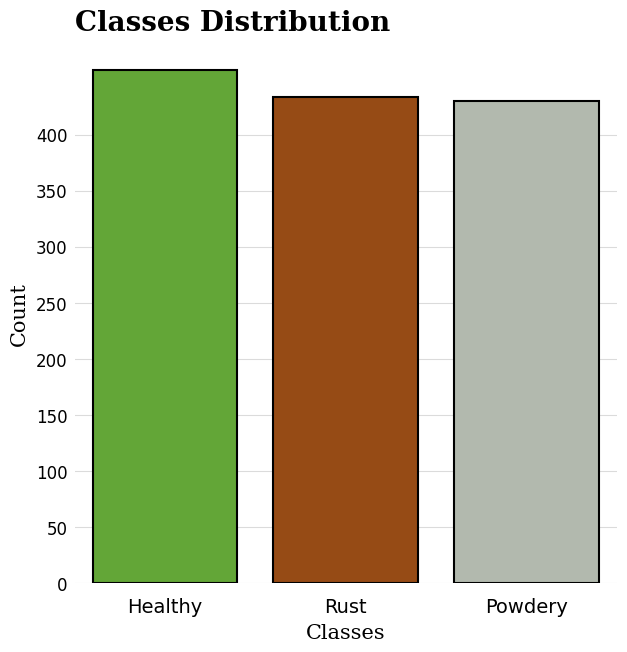

In [ ]:
label_pathes = [os.path.join(config.train_path, label) for label in train_dataset.labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 450, 50)))
ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("Count", fontsize=15, fontfamily="serif", labelpad=5)
hide_spines(ax)
fig.show()

# Prepare the Dataset & Data Loaders

In [ ]:
train_dataset = PlantDiseaseDataset(path=config.train_path,
                                    augmentations=train_config.augmentations,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path,
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape,
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path,
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape,
                                   channels=train_config.image_channels)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True,
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=train_config.batch_size*2,
                               num_workers=train_config.num_workers,
                               pin_memory=True,
                               shuffle=False,
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False,
                         collate_fn=collate_fn)

# MODEL TRAINING

In [ ]:
import torch
from torchvision import models

base_model = models.vgg16(pretrained=True)

base_model = base_model.to(train_config["device"])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in base_model.features.parameters():
  param.required_grad = False

In [ ]:
num_classes = len(train_dataset.labels)

base_model.classifier[6] = nn.Linear(4096, num_classes)

base_model = base_model.to(train_config["device"])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.classifier[6].parameters(), lr = 0.0001)

In [ ]:
for epoch in range(train_config["epochs"]):
    base_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(train_config["device"]), labels.to(train_config["device"])

        optimizer.zero_grad()
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{train_config['epochs']}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100*correct/total:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/5], Loss: 0.8695, Accuracy: 62.71%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [2/5], Loss: 0.5401, Accuracy: 86.23%
Epoch [3/5], Loss: 0.3915, Accuracy: 91.15%
Epoch [4/5], Loss: 0.3326, Accuracy: 93.04%
Epoch [5/5], Loss: 0.2957, Accuracy: 92.97%
